<img src="./pictures/logomegalomo.png" alt="Drawing" style="width: 300px;"/>

<img src="./pictures/FullPipeline.png" alt="Drawing" style="width: 1000px;"/>

# Using the Pipeline with serialized dataSet

## Packages for the pipeline

First the general packages for the pipeline

In [8]:
import sys
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import copy
import json
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Then, the pipeline itself

You have to write the path to your OmegaLoMo lib directory

In [9]:
sys.path.append('/Users/lbarlet/Desktop/omegaLoMo/lib/')
import core as ca
import createTopo as cT
import graph as graph

## Creating Topology

<img src="./pictures/Preprocessing.png" alt="Drawing" style="width: 200px;"/>

>*database* is the path to your database (Mitab format) 

>*filterIds* correspond to a list of ids which manage to detect an homologue in your Query list




>*newDic.json* contain a serialized version of a physical interactions described in Intact.
TAILLE + VISUEL (DIAG VENNES)

In [10]:
database = "/Volumes/arwen/mobi/group/divisome/physical_intact.mitab.txt"
filterIds = "/Volumes/arwen/mobi/group/divisome/anaBlast/allInR6OnlyIn"

entireTopo = cT.Topology(database, filterIds)
newDic = entireTopo.deSerialize('/Volumes/arwen/mobi/group/divisome/newDic.json')

>*newDic* is the filtered and reduced topology of your database

This will be used later to construct the **OmegaMatrix**

## Processing data

<img src="./pictures/Analysis.png" alt="Drawing" style="width: 200px;"/>

Here, you have to use the examples files provide in the git depository.

These files correspond to some subset and can be use on this notebook as a quick way to familiarise yourself with the pipeline

>*indexR6* is a list of UniprotId corresponding to the proteome of your organims

>*bean* is a serialized version of a small dataset, corresponding to a topology

>*path* is the path to a directory with some blast.out files (in xml format)

In [12]:
indexR6 = '/Volumes/arwen/mobi/group/divisome/anaBlast/indexR6'

Use the following cell if you use a serialised version

In [13]:
omegaSet = ca.HomegaSet(bean='/Volumes/arwen/mobi/group/divisome/FullOmegaSet_coverage.json',
                        queryIdList=indexR6)

Organising the HomegaSet to an **OmegaMatrix** by deleting template wich doesn't bring back queries of interest. 

The **OmegaMatrix** will project from the template space to a matrix of queries to identify all interactions the queries.

In [14]:
omegaMatrix = ca.OmegaMatrix(topo = newDic, omegaSet = omegaSet)
omegaMatrix.reduceAndVectorInject()
queryTopo = omegaMatrix.project()

   ## Selection of proteins of interest  

>*divR6Known* is a downloaded list from uniprot with the "cell division" GO term selected

<div class="alert alert-info">
    You can check out the list <a href=http://www.uniprot.org/uniprot/?query=taxonomy:%22Streptococcus%20pneumoniae%20(strain%20ATCC%20BAA-255%20/%20R6)%20[171101]%22+go:51301> here
</div>

In [15]:
divR6Known = '/Volumes/arwen/mobi/group/divisome/divKnownR6.txt'
onlyId = []
with open (divR6Known, 'r') as file_div:
    for i in xrange(1):
        file_div.next()
    for line in file_div:
        sLine = line.split("\t")
        onlyId.append(sLine[0])

Here, you can check if the parsing works fine

The next cell is suppose to print your Id list with Uniprot identifier

In [16]:
print onlyId

['Q8CWP9', 'Q8DQM0', 'P64073', 'Q8DQE5', 'P64167', 'Q8DR70', 'Q8DR57', 'Q8DNE8', 'Q8DNI9', 'Q9EUQ7', 'Q8DNS0', 'Q8DR29', 'Q7ZAK7', 'Q8DR55', 'Q8DPV4', 'Q8DP40', 'Q8DR69', 'Q8CWQ5', 'Q8DQM2', 'Q8DQM1', 'P65467', 'P59676', 'Q8DPW6', 'Q8DQH3', 'Q8DNV6', 'Q8DQH4', 'Q8DNV8', 'Q8DQE8', 'Q8CZ65', 'Q8DPK2', 'Q8DNV9']


## Graphs Functions

<img src="./pictures/Results.png" alt="Drawing" style="width: 200px;"/>

In [17]:
interactome = graph.Interactome(queryTopo)
test = interactome.drawGraph()

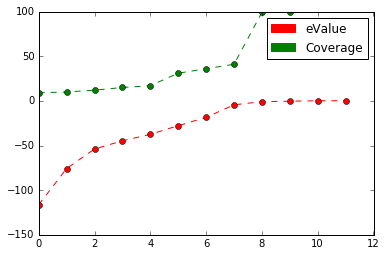

In [25]:
#test = interactome.deserializeGraph("/Users/mbachir/Desktop/omegaLoMo/testGraph/Q8DR55.json")
premierVoisin = interactome.createNeiGraph('Q8DR55', test)
drawPremierVoisin = interactome.drawNeiGraph(premierVoisin)
filtre = interactome.filterGraph(drawPremierVoisin, evalue = 2.2272e-10, coverage = 90)
stats = interactome.drawCurveParam(premierVoisin)
plt.show()

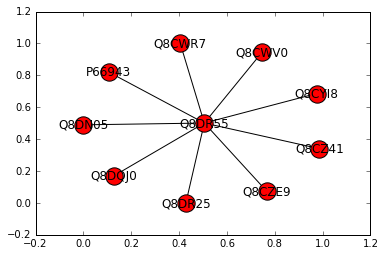

In [26]:
nx.draw_networkx(drawPremierVoisin, with_labels = True)
plt.show()

# Using your own DataSet

<div class="alert alert-danger">
This might take a while for big database
</div>

In [ ]:
database = "/Volumes/arwen/mobi/group/divisome/physical_intact.mitab.txt"
filterIds = "/Volumes/arwen/mobi/group/divisome/anaBlast/allInR6OnlyIn"

topo = cT.Topology(database, filterIds)
newDic = topo.filter_With(filterIds)

In [ ]:
indexR6 = '/Volumes/arwen/mobi/group/divisome/anaBlast/indexR6'

In [ ]:
Use the following cell if you start from multiple blast (format xml)

<div class="alert alert-warning">
    This step recquire more time, cause it's parsing all blast output
</div>

In [ ]:
omegaSet = ca.HomegaSet(path='/Volumes/arwen/mobi/group/divisome/UsineBlastArrayIntact_vs_R6/IntactVsR6/swork/Q5/',
                        queryIdList=indexR6)

In [ ]:
divR6Known = '/Volumes/arwen/mobi/group/divisome/divKnownR6.txt'
onlyId = []
with open (divR6Known, 'r') as file_div:
    for i in xrange(1):
        file_div.next()
    for line in file_div:
        sLine = line.split("\t")
        onlyId.append(sLine[0])